In [1]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
plt.rcParams['figure.figsize'] = [12, 8]
from skimage import data, img_as_float, filters
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import mean_squared_error
from skimage.io import imread, imshow
from skimage.draw import rectangle_perimeter
import pandas as pd
from sklearn.cluster import KMeans
import cv2

In [165]:
url = 'C:/Users/RedjepovTYAdmin/Downloads/fish/1108_croped/100GOPRO/G0015162.jpg'
B = np.fromfile('back.csv')
B = B.reshape((2000,2500))

In [166]:
im = imread(url, as_gray=True)
rows, cols = im.shape

In [167]:
# v3
wx=50
wy=150
stepx=13
stepy=13
xn = (cols-wx)//stepx + 1
yn = (rows-wy)//stepy + 1
R = np.zeros((yn, xn))
for i in range(yn+1):
    for j in range(xn+1):
        # no fish
        a1 = B[i*stepy:i*stepy+wy, j*stepx:j*stepx+wx]
        
        # with fish
        a2 = im[i*stepy:i*stepy+wy, j*stepx:j*stepx+wx]

        # esli okno temnee na 30% chem fon, scoree vsego eto ryba
        if (1.25 * a2.mean() < a1.mean()) & (i*stepy > 1250 - j*stepx) & (i*stepy > j*stepx - 850) & (i*stepy < 1.4*j*stepx + 1300):
            R[i-1][j-1] = a1.mean() - a2.mean()

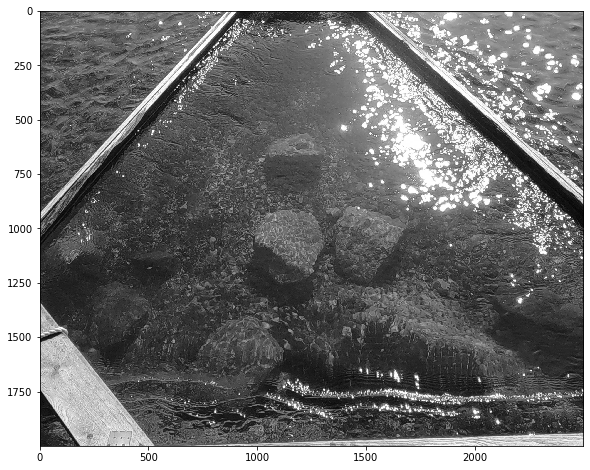

In [168]:
fig, ax = plt.subplots(1,1)
ax.imshow(im, cmap="gray");
#ax.plot(cc, rr, "--r");
#ax.plot(cc2, rr2, "--r");

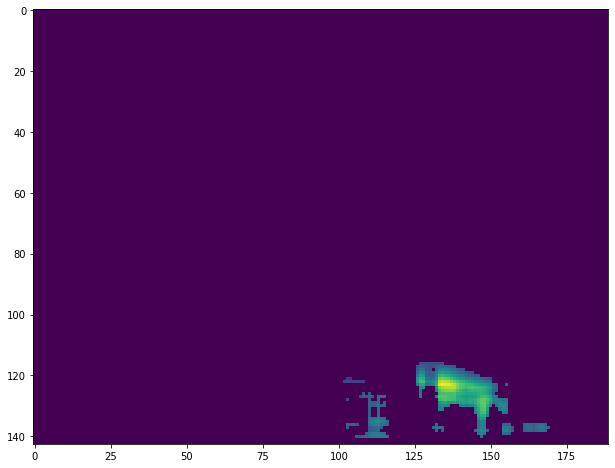

In [169]:
#q = image1.shape[0] / R.shape[0]
fig, ax = plt.subplots(1,1)
ax.imshow(R)

In [170]:
R.shape

(143, 189)

### Centroids

In [152]:
z = []
for i in range(1, R.shape[0]):
    for j in range(1, R.shape[1]):
        if (R[i][j] > 0.05):
            z.append((i, j, R[i][j]))

In [153]:
df = pd.DataFrame(z, columns=['y', 'x', 'w'])

In [154]:
df.shape[0]

173

In [155]:
error_decrease = 0.03
if df.shape[0] > 1000:
    error_decrease = 0.02

In [156]:
Sum_of_squared_distances = []
K = range(1,20)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(df[['x', 'y']], sample_weight=df['w'])
    Sum_of_squared_distances.append(km.inertia_)

In [157]:
def get_n_clusters(scores):
    n=0
    for i in scores:
        if i/sum(scores) < error_decrease:
            return n
            break
        else:
            n+=1

N = get_n_clusters(Sum_of_squared_distances)
N

2

In [158]:
kmeans = KMeans(n_clusters=N, random_state=0).fit(df[['x', 'y']])

In [159]:
kmeans.cluster_centers_

array([[109.        ,  66.27083333],
       [147.5974026 , 126.88311688]])

In [160]:
res = []
for c in kmeans.cluster_centers_:
    x = int(c[0])
    y = int(c[1])
    slc = R[y-12:y+12, x-4:x+4]
    if slc.shape[0] > 0 and slc.shape[1] > 0:
        if slc.mean() > 0.04:
            res.append((x, y))
    #tdf = df[(abs(df['x']-x) < 10) & (abs(df['y']-y) < 30)]
    #if (tdf['x'].nunique() > 4) and (tdf['y'].nunique() > 7) and (tdf.shape[0] > 15):
        #print(c, tdf['x'].nunique(), tdf['y'].nunique(), tdf.shape)
print(len(res))

1


In [161]:
res

[(109, 66)]

In [162]:
def dist(p1, p2):
    return np.sqrt((p1[0]-p2[0])**2 + ((p1[1]-p2[1])/3)**2)


print(res)
for _ in range(len(res)):
    cres = res.copy()
    for i in range(len(res)):
        for j in range(1, len(res)):
            if i<j:
                print(res[i], res[j], dist(res[i], res[j]))
                if dist(res[i], res[j]) < 15:
                    q = cres.pop(i)
                    w = cres.pop(j-1)
                    cres.append(((q[0]+w[0])/2, (q[1]+w[1])/2))  
            break
        break
    res = cres.copy()
        
cres    

[(109, 66)]


[(109, 66)]

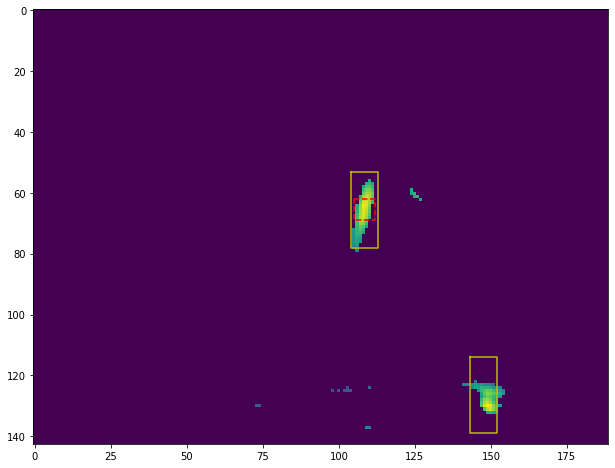

In [163]:
fig, ax = plt.subplots(1,1)
ax.imshow(R)
for c in kmeans.cluster_centers_:
    start = (c[1]-12, c[0]-4)
    extent = (24, 8)
    rr, cc = rectangle_perimeter(start, extent=extent, shape=R.shape)
    ax.plot(cc, rr, "-y");
    
for c in cres:
    start = (c[1]-3, c[0]-3)
    extent = (6, 6)
    rr, cc = rectangle_perimeter(start, extent=extent, shape=R.shape)
    ax.plot(cc, rr, "--r");

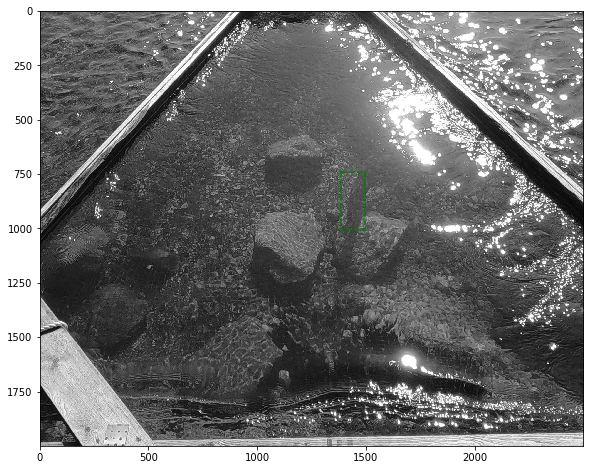

In [164]:
fig, ax = plt.subplots(1,1)
ax.imshow(im, cmap='gray')
q = im.shape[1]/R.shape[1]
for c in cres:
    start = ((c[1]-10)*q, (c[0]-4)*q)
    extent = (20*q, 8*q)
    rr, cc = rectangle_perimeter(start, extent=extent, shape=im.shape)
    ax.plot(cc, rr, "--g");